processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


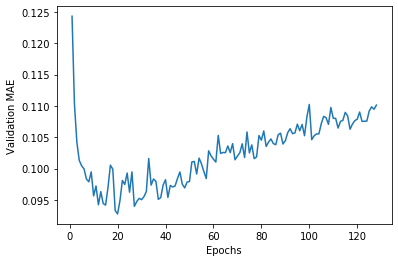

499/499 [==============================] - 0s 386us/step

 MSE SCORE:  0.016628333023993788

 MAE SCORE:  0.09149320423603058


In [2]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 17 21:53:45 2020

@author: vatsal
"""

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense
from keras.models import Sequential
from keras.models import load_model
from sklearn.impute import SimpleImputer
from keras.callbacks import ModelCheckpoint

#Function for loading the data
def load_crime_data():
    
    data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data',header=None)
    data = data.replace('?',np.nan)
    new_data = data.iloc[:,5:].values
    #new_data = new_data.astpye("float")
    missingvalues = SimpleImputer(missing_values = np.nan , strategy = 'mean', verbose=0)
    missingvalues = missingvalues.fit(new_data[:,5:])
    new_data[:,5:]= missingvalues.transform(new_data[:,5:])
    x = new_data[:,:-1]
    y = new_data[:,122]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, shuffle = True)
    return x_train, x_test, y_train, y_test

x_train,x_test, y_train, y_test = load_crime_data()

#Function for builiding the model    
def build_model():
    
    model = Sequential()
    model.add(Dense(64,activation='relu',input_shape=(122,)))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='Adam', loss='mean_squared_error',metrics=['mean_absolute_error'])
    return model

#Perdoming k fold cross-validation
k = 5
num_val_samples = len(x_train)//k

all_mae_histories = []
for i in range(k):
    print('processing fold #', i)

    # Prepare the validation data: data from partition # k
    x_val = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    y_val = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate([x_train[:i * num_val_samples], x_train[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([y_train[:i * num_val_samples], y_train[(i + 1) * num_val_samples:]], axis=0)

     # Build the Keras model (already compiled)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(x_val, y_val), epochs=128, batch_size=64,
                        verbose=0)

    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

#Calculating average validation errors for k-fold cross validation    
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(128)]

#Plotting the validation error
plt.plot(range(1,len(average_mae_history)+1),average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#Saving the model
model.save('task_3.h5')
model = load_model('task_3.h5')

#Retraining the final model
model = build_model()
model.fit(x_train,y_train,epochs=22, batch_size=64, verbose=0)

#Evalucating the model on test set
test_mse_score, test_mae_score = model.evaluate(x_test, y_test) 
print("\n MSE SCORE: ",test_mse_score)
print("\n MAE SCORE: ",test_mae_score)   
